In [19]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

In [2]:
df = pd.read_csv('prediction.csv')

In [3]:
df.head()

,Unnamed: 0,country,population,area,density,coastline_area_ratio,net_migration,infant_mortality,gdp_per_capita,literacy,...,region_BALTICS,region_C.W. OF IND. STATES,region_EASTERN EUROPE,region_LATIN AMER. & CARIB,region_NEAR EAST,region_NORTHERN AFRICA,region_NORTHERN AMERICA,region_OCEANIA,region_SUB-SAHARAN AFRICA,region_WESTERN EUROPE
0,0,Afghanistan,31056997,647500,48.0,0.00,23.06,163.07,700.0,36.0,...,0,0,0,0,0,0,0,0,0,0
1,1,Albania,3581655,28748,124.6,1.26,-4.93,21.52,4500.0,86.5,...,0,0,1,0,0,0,0,0,0,0
2,2,Algeria,32930091,2381740,13.8,0.04,-0.39,31.00,6000.0,70.0,...,0,0,0,0,0,1,0,0,0,0
3,3,American Samoa,57794,199,290.4,58.29,-20.71,9.27,8000.0,97.0,...,0,0,0,0,0,0,0,1,0,0
4,4,Andorra,71201,468,152.1,0.00,6.60,4.05,19000.0,100.0,...,0,0,0,0,0,0,0,0,0,1


##### Data Split 1: all of our final dataset, no scaling


In [4]:
y = df['gdp_per_capita']
X = df.drop(['gdp_per_capita','country'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

##### Data Split 2: all of our final dataset, with scaling


In [5]:
sc_X = StandardScaler()

X2_train = sc_X.fit_transform(X_train)
X2_test = sc_X.fit_transform(X_test)
y2_train = y_train
y2_test = y_test


##### Data Split 3: feature selected dataset, no scaling

In [6]:
y3 = y
X3 = df.drop(['gdp_per_capita','country','population', 'area', 'coastline_area_ratio', 'arable',
                      'crops', 'other', 'climate', 'deathrate', 'industry'], axis=1)

X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.2, random_state=101)


##### Data Split 4: feature selected dataset, with scaling

In [8]:
sc_X4 = StandardScaler()

X4_train = sc_X4.fit_transform(X3_train)
X4_test = sc_X4.fit_transform(X3_test)
y4_train = y3_train
y4_test = y3_test

## Random Forest

Let's first try random forest with our data splits (with and without feature selection). Scaling is not going to be tested for Random Forest, since it should not affect this algorithm's performance. later we will try to improve its performance.

##### Model Training

In [12]:
rf1 = RandomForestRegressor(random_state=101, n_estimators=200)
rf3 = RandomForestRegressor(random_state=101, n_estimators=200)

rf1.fit(X_train, y_train)
rf3.fit(X3_train, y3_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=200, n_jobs=None, oob_score=False,
                      random_state=101, verbose=0, warm_start=False)

In [13]:
rf1_pred = rf1.predict(X_test)
rf3_pred = rf3.predict(X3_test)

In [14]:
print('Random Forest Performance:')

print('\nall features, No scaling:')
print('MAE:', metrics.mean_absolute_error(y_test, rf1_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, rf1_pred)))
print('R2_Score: ', metrics.r2_score(y_test, rf1_pred))

print('\nselected features, No scaling:')
print('MAE:', metrics.mean_absolute_error(y3_test, rf3_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y3_test, rf3_pred)))
print('R2_Score: ', metrics.r2_score(y3_test, rf3_pred))

Random Forest Performance:

all features, No scaling:
MAE: 2207.804347826087
RMSE: 3207.952113244455
R2_Score:  0.8754543660363124

selected features, No scaling:
MAE: 2403.358695652174
RMSE: 3549.0739491787335
R2_Score:  0.847558627188669


fig = plt.figure(figsize=(12, 6))
plt.scatter(y_test,rf1_pred,color='coral', linewidths=2, edgecolors='k')
plt.xlabel('True GDP per Capita') 
plt.ylabel('Predictions') 
plt.title('Random Forest prediction Performance (No feature selection)') 
plt.grid()
plt.show()

#### Optimization

We will use grid search in order to obtain good parameters for our RF regressor. Of course our optimization here will be limited due to time and computing power constraints. The parameters we will optimize are: 

1. n-estimators 
2. min_samples_leaf
3. max_features
4. bootstrap

In [17]:
rf_param_grid = {'max_features': ['sqrt', 'auto'],
              'min_samples_leaf': [1, 3, 5],
              'n_estimators': [100, 500, 1000],
             'bootstrap': [False, True]} 

In [20]:
rf_grid = GridSearchCV(estimator= RandomForestRegressor(), param_grid = rf_param_grid,  n_jobs=-1, verbose=0)

In [21]:
rf_grid.fit(X_train,y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n

In [22]:
rf_grid.best_params_

{'bootstrap': False,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'n_estimators': 100}

In [23]:
rf_grid.best_estimator_

RandomForestRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='sqrt', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [24]:
rf_grid_predictions = rf_grid.predict(X_test)

In [25]:
print('MAE:', metrics.mean_absolute_error(y_test, rf_grid_predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, rf_grid_predictions)))
print('R2_Score: ', metrics.r2_score(y_test, rf_grid_predictions))

MAE: 2201.6739130434785
RMSE: 2961.5842668351033
R2_Score:  0.8938497692158326


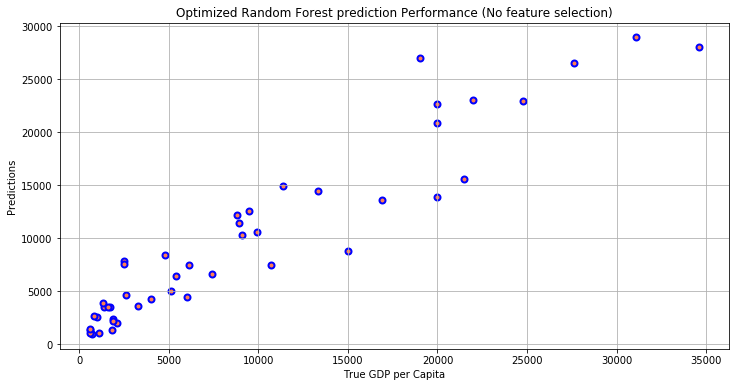

In [27]:
fig = plt.figure(figsize=(12, 6))
plt.scatter(y_test,rf_grid_predictions, linewidths=2, edgecolors='b', color='coral')
plt.xlabel('True GDP per Capita') 
plt.ylabel('Predictions') 
plt.title('Optimized Random Forest prediction Performance (No feature selection)') 
plt.grid()
plt.show()

We can see that the optimization process on RF regressor has not changed the performance in a noticeable manner, yet the slight change was actually to the worst, that is probably because our initial parameters were already very close to the optimum ones.